In [1]:
from pathlib import Path
import pandas as pd

In [2]:
from ethicml.algorithms.inprocess import GPyT, GPyTDemPar, GPyTEqOdds, LR, SVM, Agarwal, Kamiran, Kamishima, LRCV, ZafarEqOpp, ZafarAccuracy, ZafarFairness
from ethicml.evaluators import evaluate_models, CrossValidator, run_metrics, evaluate_models_parallel
from ethicml.data import Compas, Adult, load_data
from ethicml.metrics import Accuracy, ProbPos, TPR, TNR, AbsCV, ProbPos, F1
from ethicml.preprocessing import train_test_split, ProportionalTrainTestSplit
from ethicml.visualisation.plot import plot_results, single_plot

In [3]:
eo_results = evaluate_models_parallel(
    datasets=[Compas("Race"), Compas("Sex")],
    inprocess_models=[
        LR(),
        LRCV(),
        SVM(),
        Agarwal(fairness="EqOd"),
        Kamiran(),
#     Kamishima(),
        ZafarEqOpp(),
    ],
    metrics=[Accuracy(), TPR(), TNR(), F1()],
    per_sens_metrics=[TPR(), TNR()], 
    repeats=3,
    splitter=ProportionalTrainTestSplit(),
    topic="only_baselines_f1",
    max_parallel=2,
)

100%|██████████| 36/36 [01:58<00:00,  3.78s/it, model=ZafarEqOpp, τ=5.0, μ=1.2, dataset=Compas Sex - Train (2), worker_id=0]  


In [4]:
eo_results.data

Accuracy  \
dataset     transform    model                      split_id             
Compas Race no_transform Logistic Regression, C=1.0 0         0.678021   
                         LRCV                       0         0.668289   
                         SVM                        0         0.688564   
                         Agarwal LR                 0         0.671533   
                         Kamiran & Calders LR       0         0.676399   
...                                                                ...   
Compas Sex  no_transform LRCV                       2         0.673420   
                         SVM                        2         0.678282   
                         Agarwal LR                 2         0.675851   
                         Kamiran & Calders LR       2         0.672609   
                         ZafarEqOpp, τ=5.0, μ=1.2   2         0.671799   

                                                                    F1  \
dataset     transform    model                      split_id             
Compas Race no_transform Logistic Regression, C=1.0 0         0.611926   
                         LRCV                       0         0.606352   
                         SVM                        0         0.619802   
                         Agarwal LR                 0         0.605648   
                         Kamiran & Calders LR       0         0.609207   
...                                                                ...   
Compas Sex  no_transform LRCV                       2         0.606061   
                         SVM                        2         0.605760   
                         Agarwal LR                 2         0.611650   
                         Kamiran & Calders LR       2         0.606238   
                         ZafarEqOpp, τ=5.0, μ=1.2   2         0.607938   

                                                                   TNR  \
dataset     transform    model                      split_id             
Compas Race no_transform Logistic Regression, C=1.0 0         0.778274   
                         LRCV                       0         0.757440   
                         SVM                        0         0.797619   
                         Agarwal LR                 0         0.769345   
                         Kamiran & Calders LR       0         0.778274   
...                                                                ...   
Compas Sex  no_transform LRCV                       2         0.775298   
                         SVM                        2         0.791667   
                         Agarwal LR                 2         0.772321   
                         Kamiran & Calders LR       2         0.772321   
                         ZafarEqOpp, τ=5.0, μ=1.2   2         0.766369   

                                                              TNR_race_0  \
dataset     transform    model                      split_id               
Compas Race no_transform Logistic Regression, C=1.0 0           0.747596   
                         LRCV                       0           0.730769   
                         SVM                        0           0.752404   
                         Agarwal LR                 0           0.733173   
                         Kamiran & Calders LR       0           0.745192   
...                                                                  ...   
Compas Sex  no_transform LRCV                       2                NaN   
                         SVM                        2                NaN   
                         Agarwal LR                 2                NaN   
                         Kamiran & Calders LR       2                NaN   
                         ZafarEqOpp, τ=5.0, μ=1.2   2                NaN   

                                                              TNR_race_0-race_1  \
dataset     transform    model                      split_id                      
Compas Race no_tra

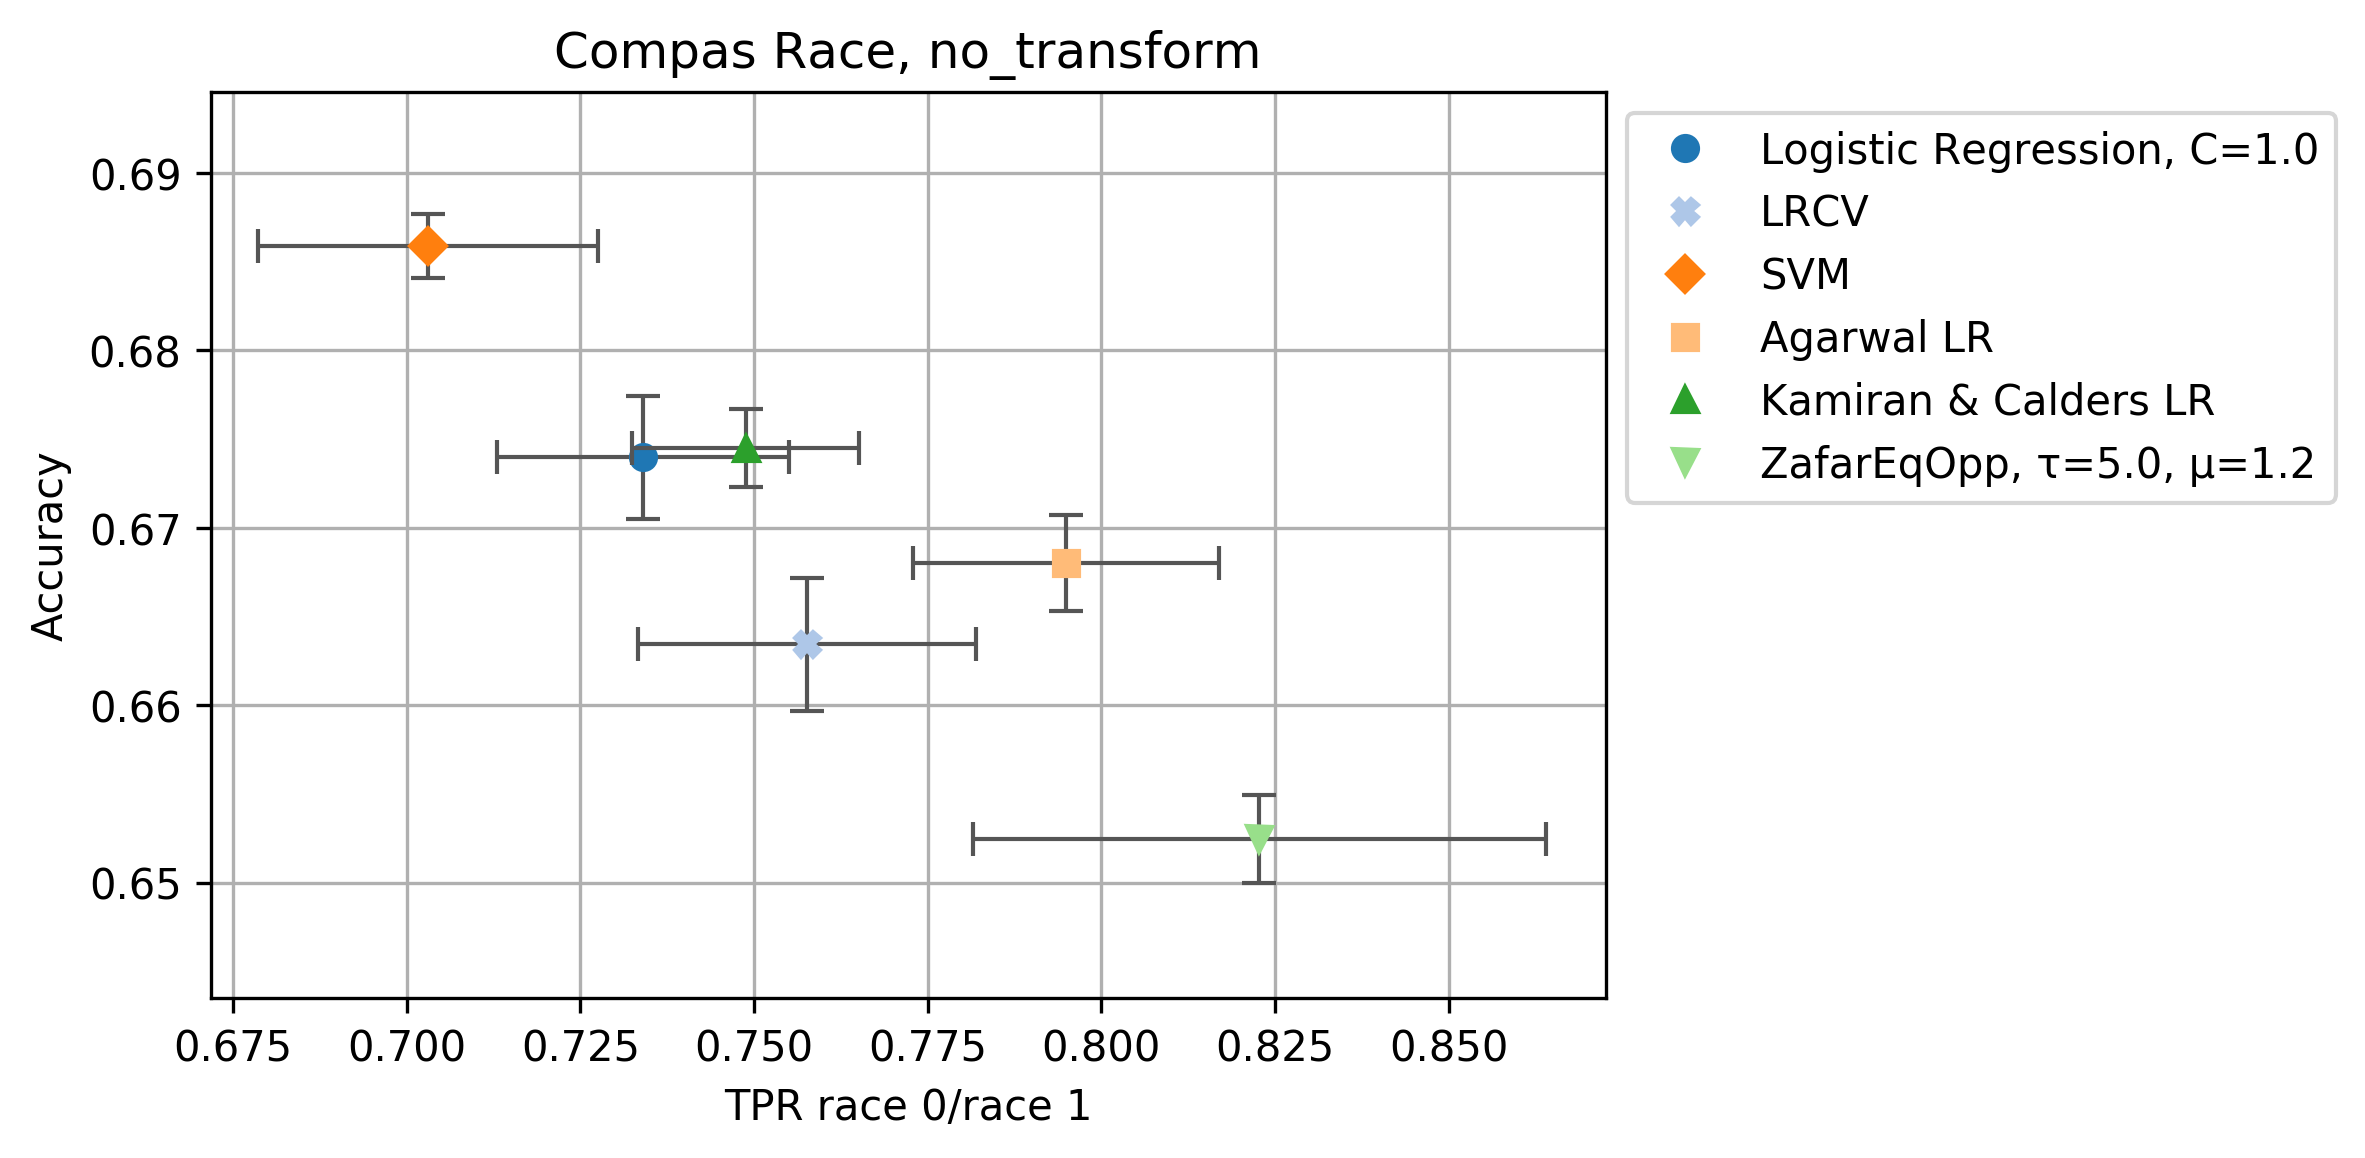

In [6]:
# results = pd.read_csv("results/Compas Race_no_transform.csv").set_index(["dataset", "transform", "model", "repeat"])

plot_results(eo_results, "Accuracy", "TPR_race_0/race_1", save=False, ptype="cross")[0][0]

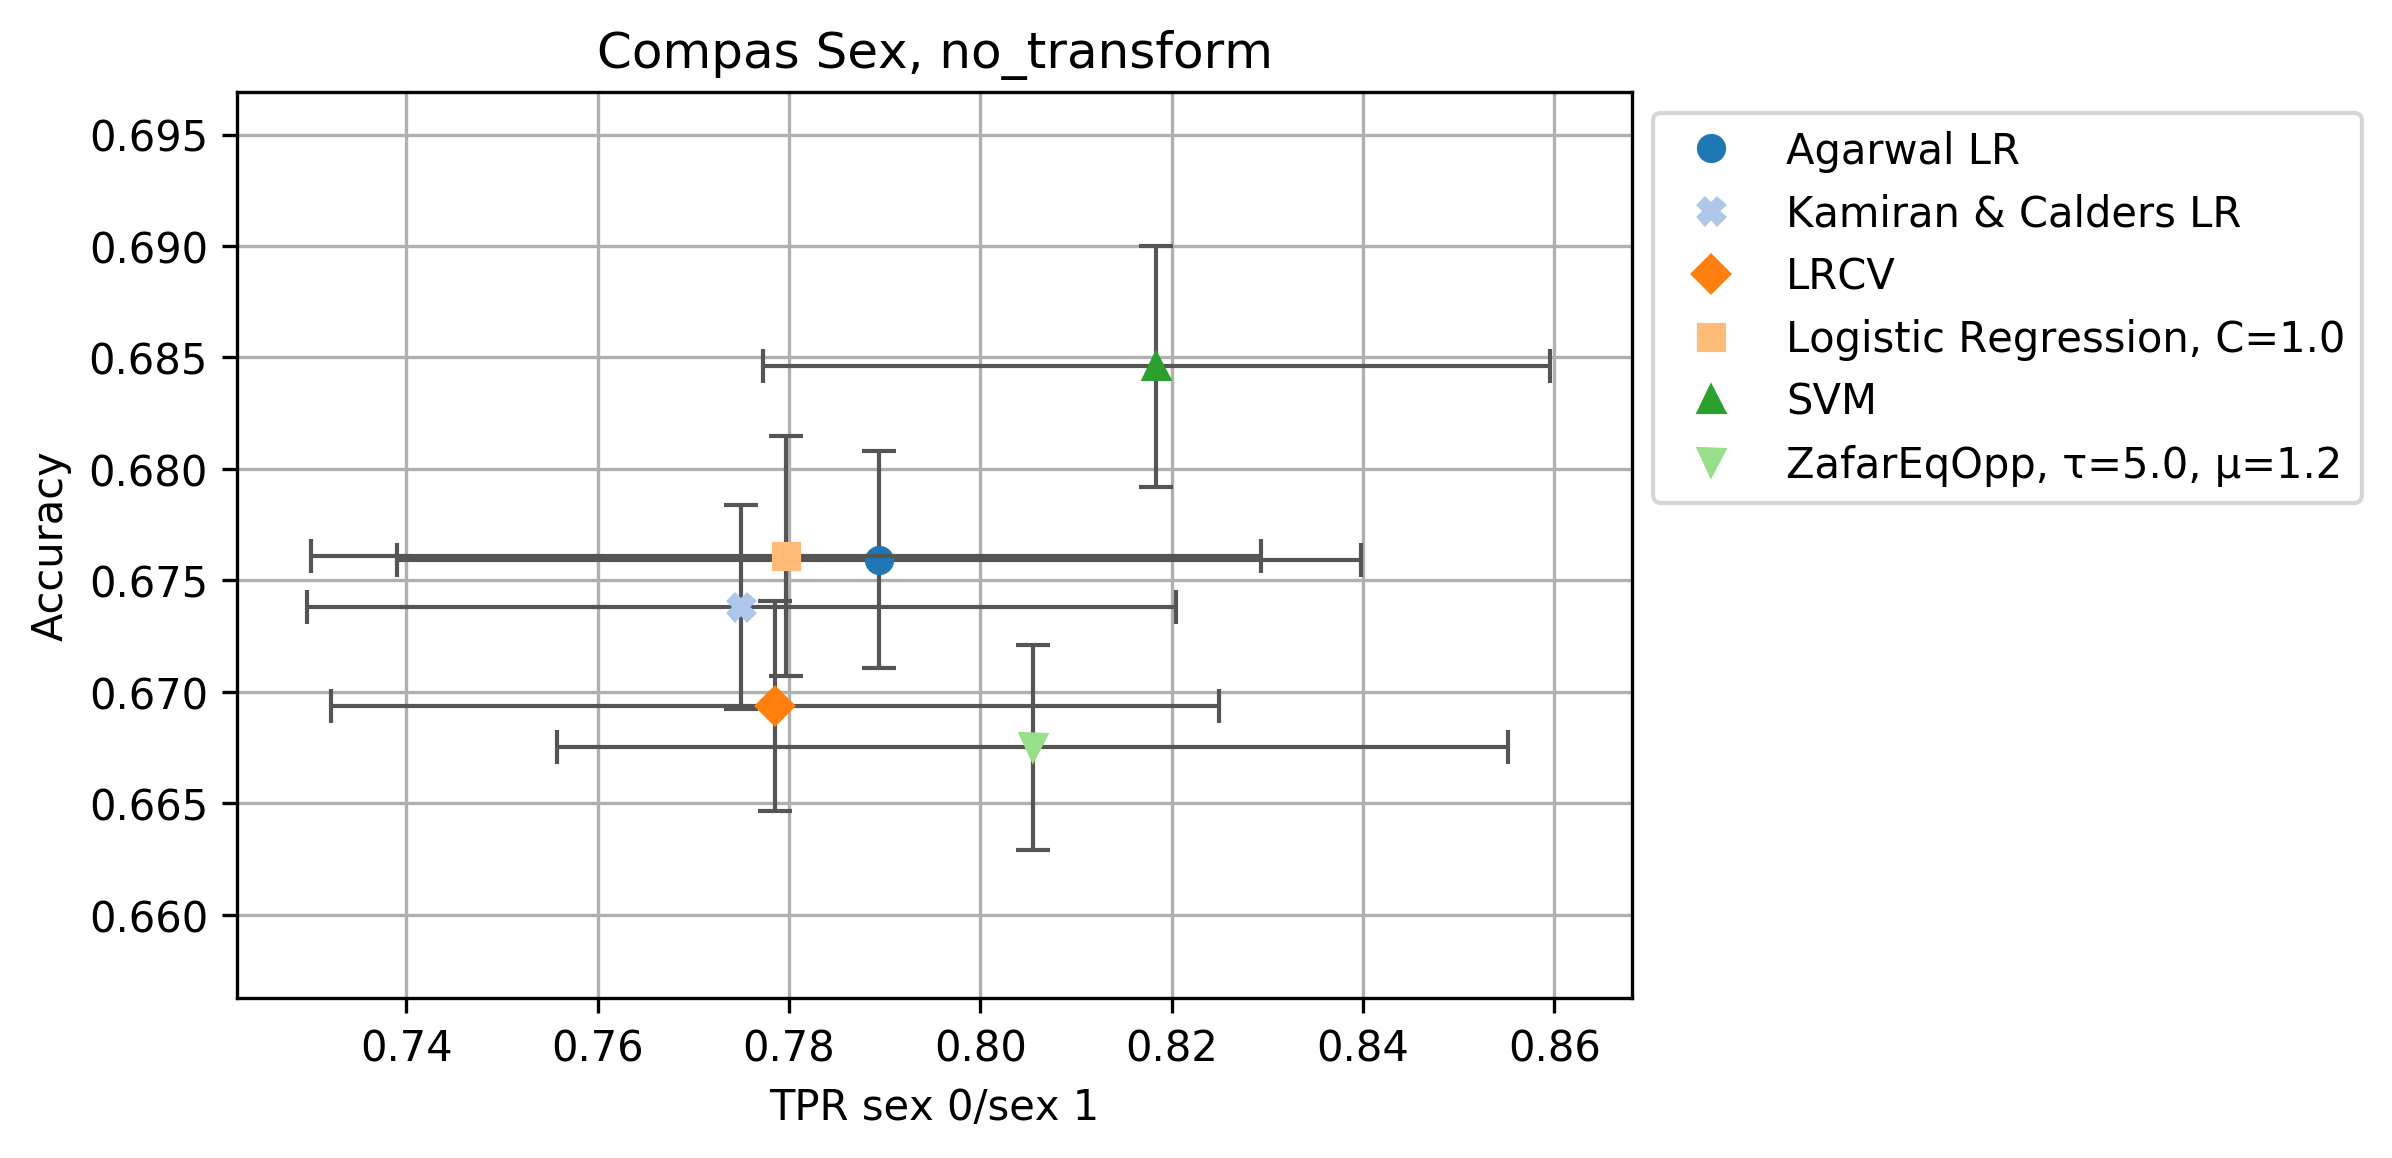

In [11]:
plot_mean_std_box(results, "Accuracy", "TPR_sex_0/sex_1", save=False, use_cross=True)[0][0]

In [7]:
adult_race = Adult("Race")
adult_race.sens_attrs = ['race_White']  # make s binary

dp_results = evaluate_models_parallel(
    datasets=[adult_race, Adult("Sex")],
    inprocess_models=[
        Agarwal(fairness="DP"),
        Kamiran(),
#         Kamishima(),
#         ZafarAccuracy(),
#         ZafarFairness(),
        LR(),
        LRCV(),
        SVM(),
    ],
    metrics=[Accuracy(), ProbPos(), AbsCV(), F1()],
    per_sens_metrics=[ProbPos()], 
    repeats=3,
    splitter=ProportionalTrainTestSplit(),
    topic="only_baselines_f1",
    max_parallel=3,
)

100%|██████████| 30/30 [07:49<00:00, 36.23s/it, model=SVM, dataset=Adult Sex - Train (2), worker_id=0]                        


In [8]:
dp_results.data

Accuracy  \
dataset    transform    model                      split_id             
Adult Race no_transform Agarwal LR                 0         0.847192   
                        Kamiran & Calders LR       0         0.846970   
                        Logistic Regression, C=1.0 0         0.847192   
                        LRCV                       0         0.804954   
                        SVM                        0         0.863667   
                        Agarwal LR                 0         0.847192   
                        Kamiran & Calders LR       0         0.846970   
                        Logistic Regression, C=1.0 0         0.847192   
                        LRCV                       0         0.804954   
                        SVM                        0         0.863667   
                        Agarwal LR                 1         0.852941   
                        Kamiran & Calders LR       1         0.852388   
                        Logistic Regression, C=1.0 1         0.852941   
                        LRCV                       1         0.806833   
                        SVM                        1         0.860681   
                        Agarwal LR                 0         0.847192   
                        Kamiran & Calders LR       0         0.846970   
                        Logistic Regression, C=1.0 0         0.847192   
                        LRCV                       0         0.804954   
                        SVM                        0         0.863667   
                        Agarwal LR                 1         0.852941   
                        Kamiran & Calders LR       1         0.852388   
                        Logistic Regression, C=1.0 1         0.852941   
                        LRCV                       1         0.806833   
                        SVM                        1         0.860681   
                        Agarwal LR                 2         0.851393   
                        Kamiran & Calders LR       2         0.851061   
                        Logistic Regression, C=1.0 2         0.851393   
                        LRCV                       2         0.812362   
                        SVM                        2         0.865767   
Adult Sex  no_transform Agarwal LR                 0         0.843339   
                        Kamiran & Calders LR       0         0.840133   
                        Logistic Regression, C=1.0 0         0.845661   
                        LRCV                       0         0.801658   
                        SVM                        0         0.859480   
                        Agarwal LR                 0         0.843339   
                        Kamiran & Calders LR       0         0.840133   
                        Logistic Regression, C=1.0 0         0.845661   
                        LRCV                       0         0.801658   
                        SVM                        0         0.859480   
                        Agarwal LR                 1         0.847540   
                        Kamiran & Calders LR       1         0.842123   
                        Logistic Regression, C=1.0 1         0.848977   
                        LRCV                       1         0.807960   
                        SVM                        1         0.863239   
                        Agarwal LR                 0         0.843339   
                        Kamiran & Calders LR       0         0.840133   
                        Logistic Regression, C=1.0 0         0.845661   
                        LRCV                       0         0.801658   
                        SVM                        0         0.859480   
                        Agarwal LR                 1         0.847540   
                        Kamiran & Calders LR       1         0.842123   
                        Logistic Regression, C=1.0 1         0.848977   
                        LRCV                  

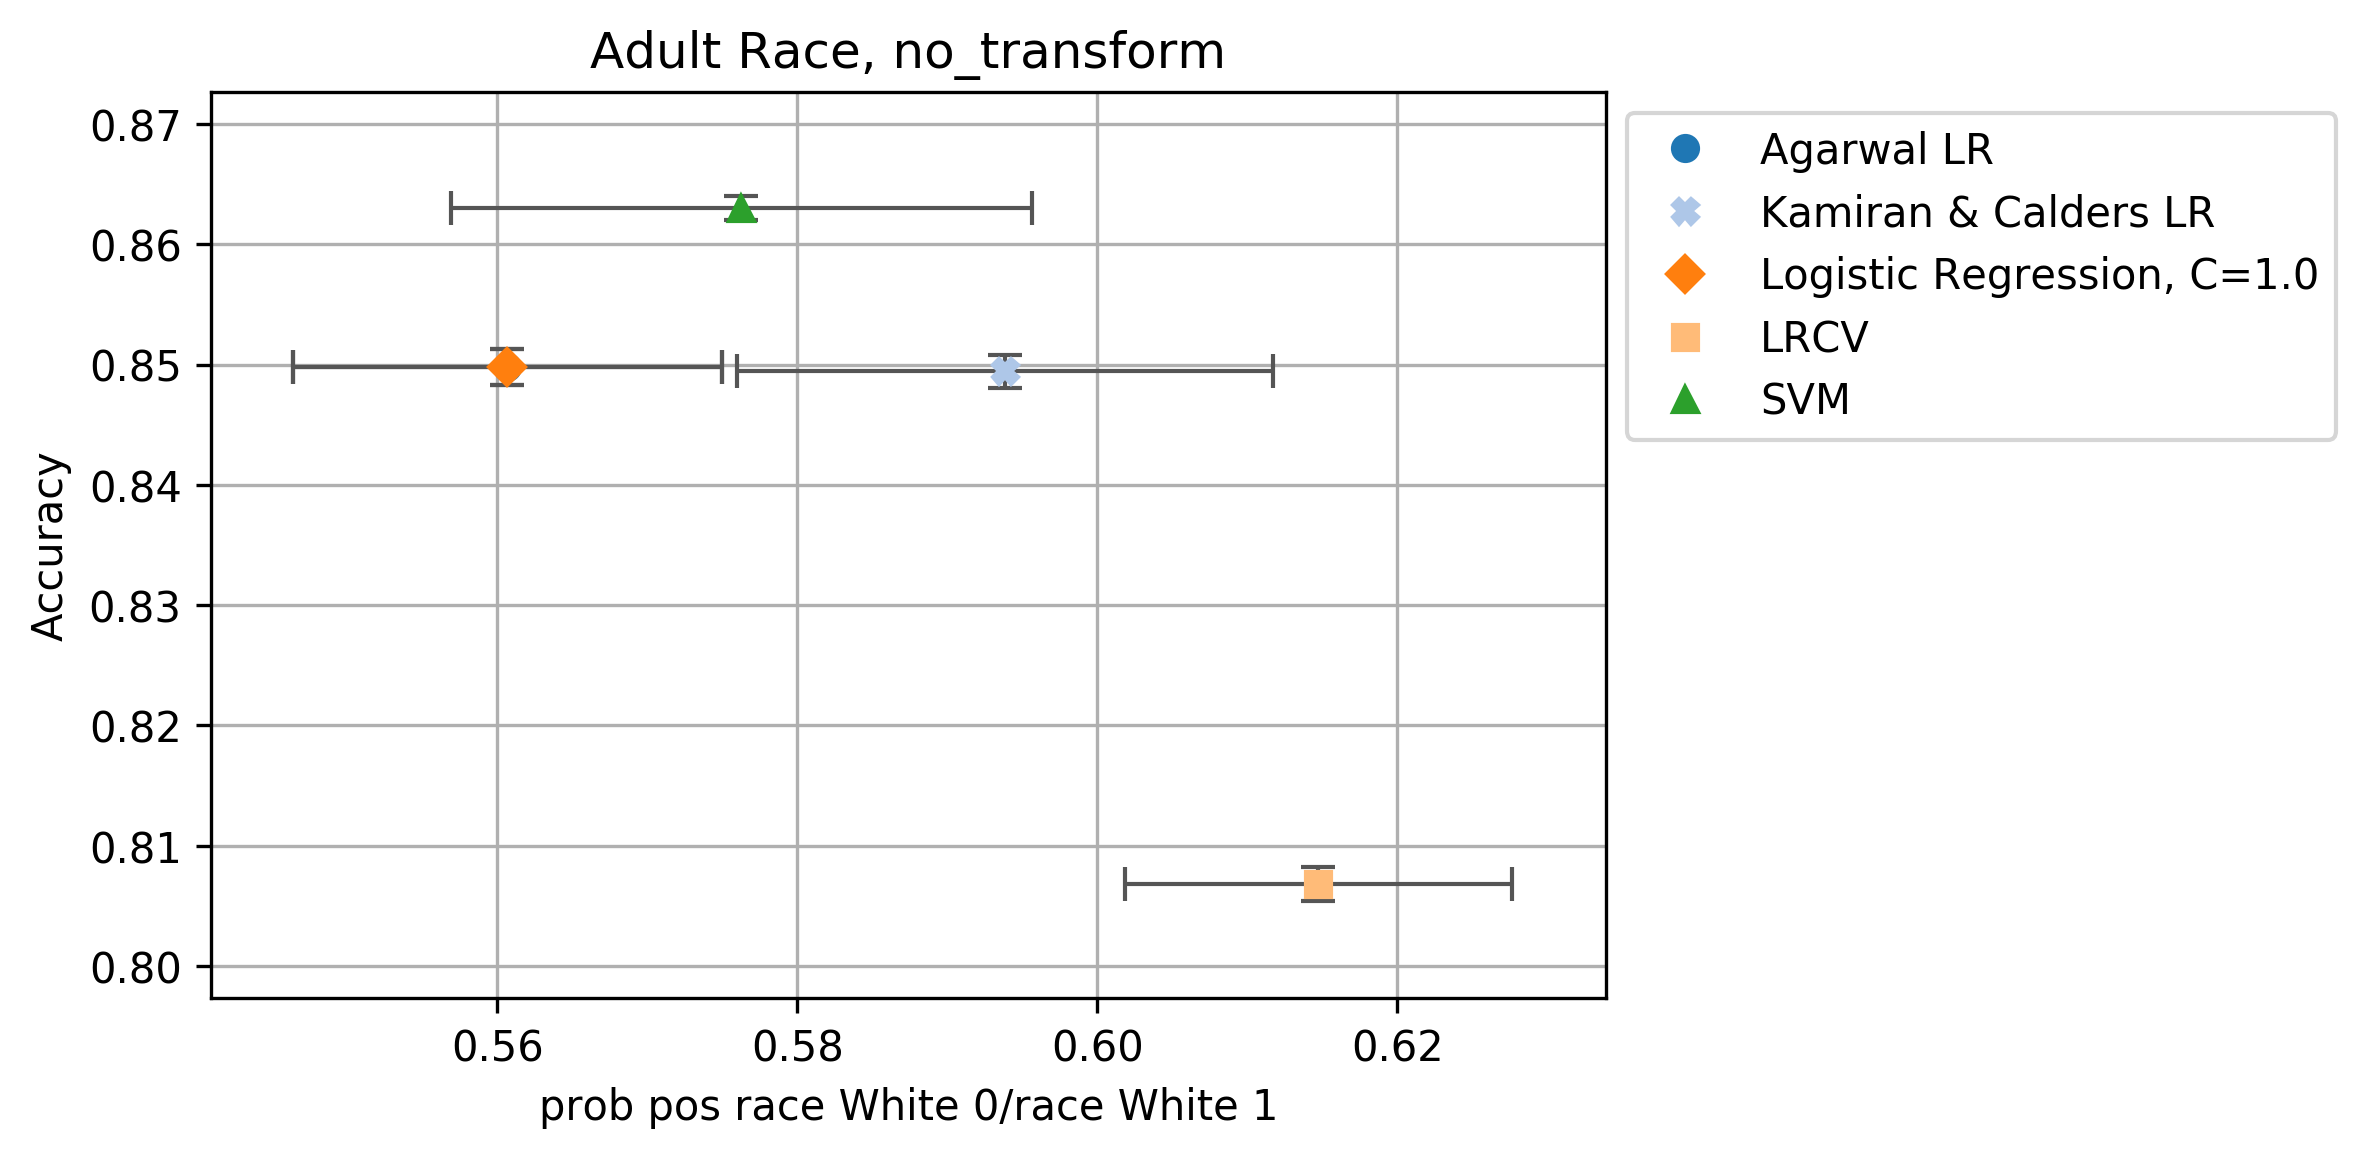

In [9]:
plot_results(dp_results, "Accuracy", "prob_pos_race_White_0/race_White_1", save=False, ptype="cross")[0][0]

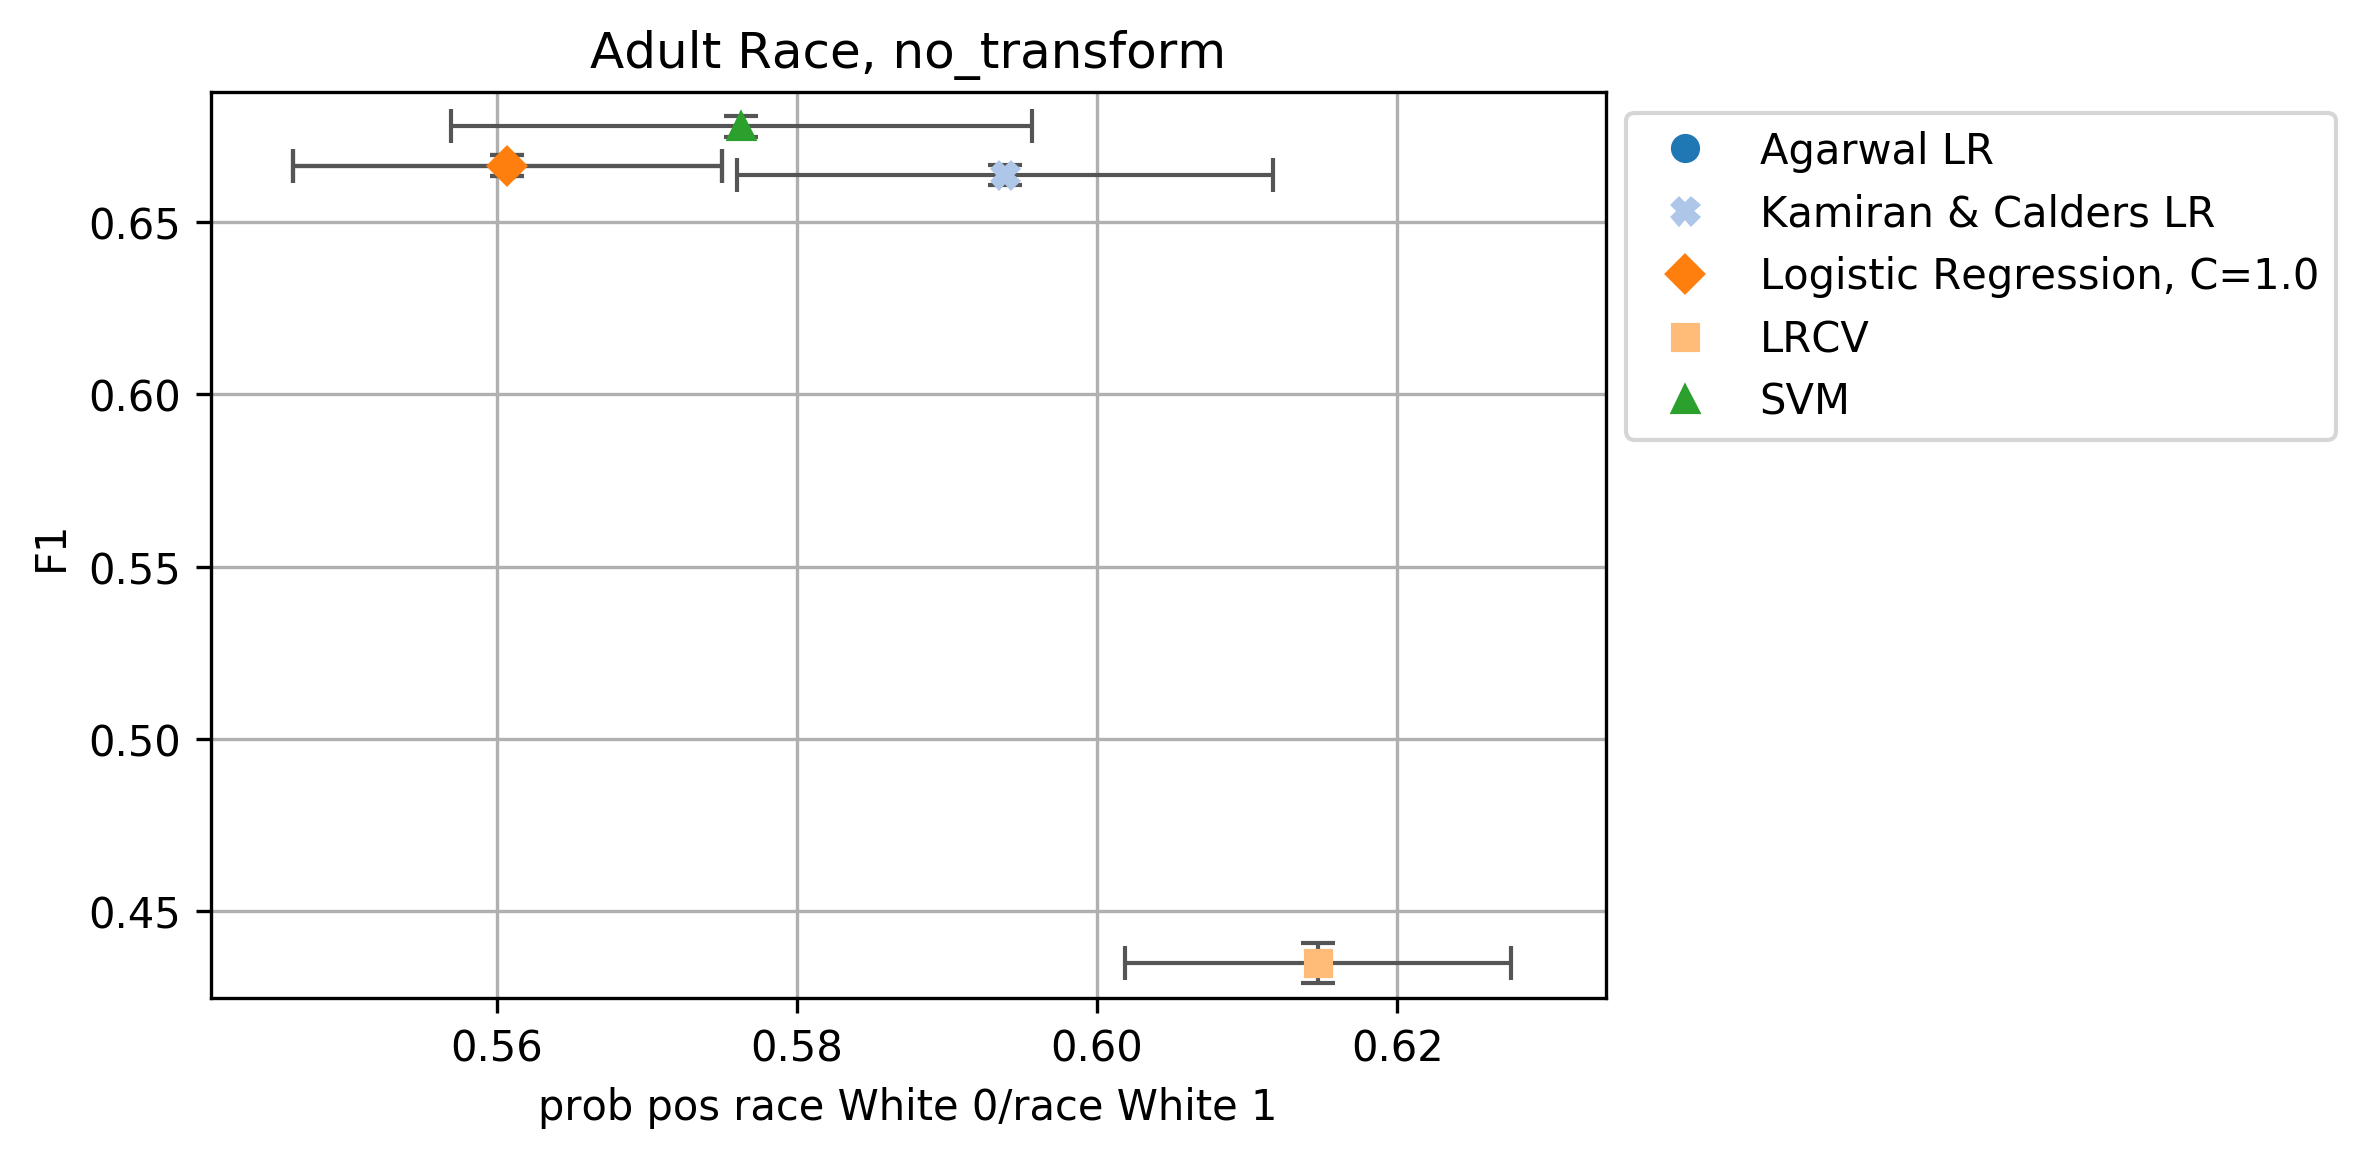

In [11]:
plot_results(dp_results, "F1", "prob_pos_race_White_0/race_White_1", save=False, ptype="cross")[0][0]

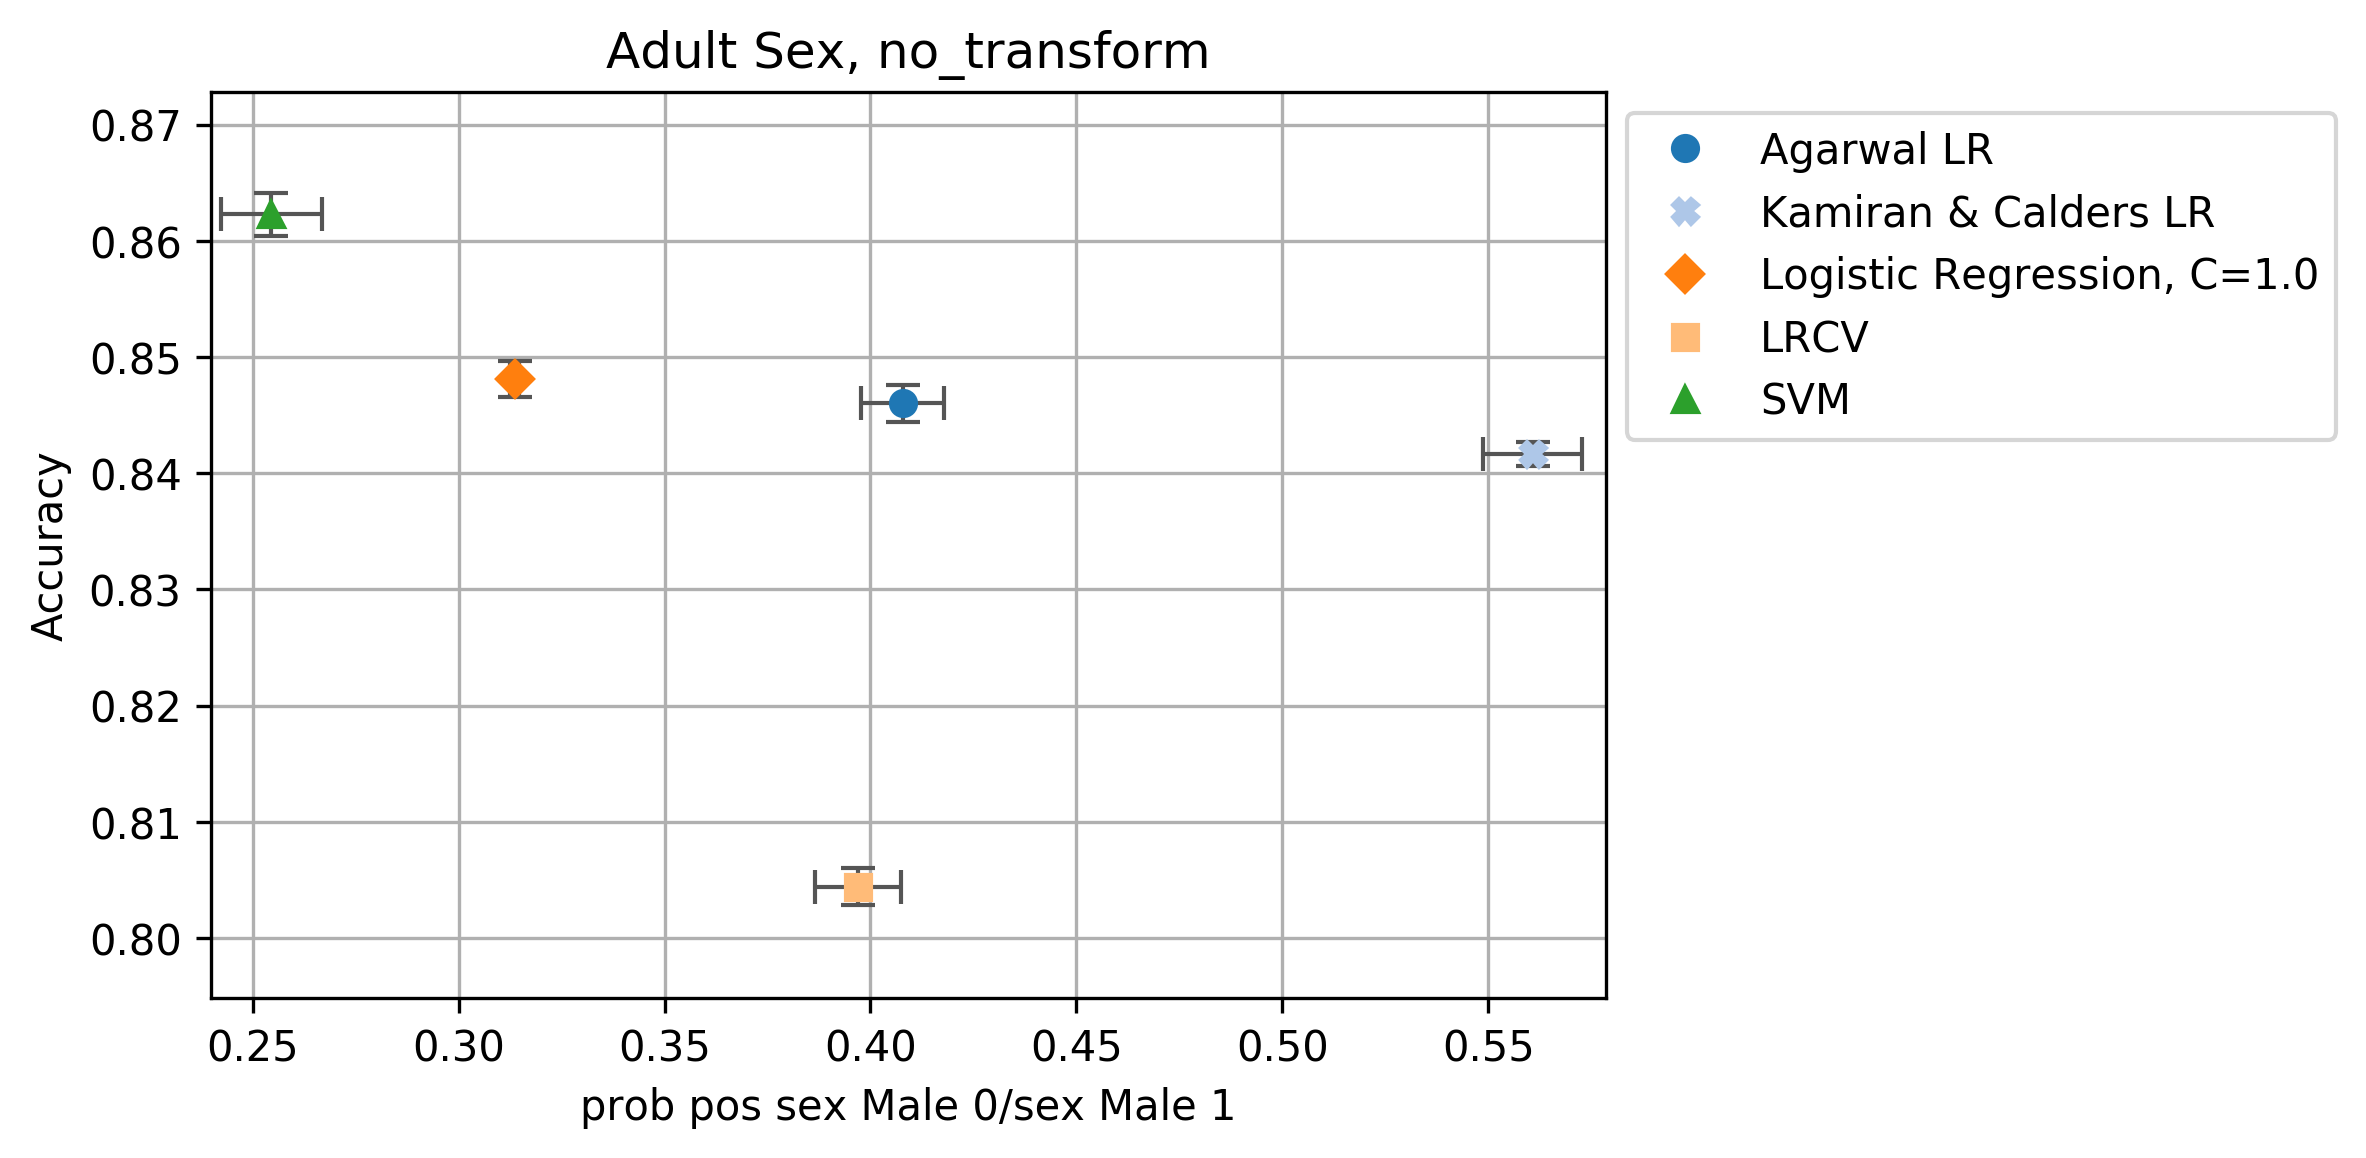

In [13]:
plot_results(dp_results, "Accuracy", "prob_pos_sex_Male_0/sex_Male_1", save=False, ptype="cross")[0][0]

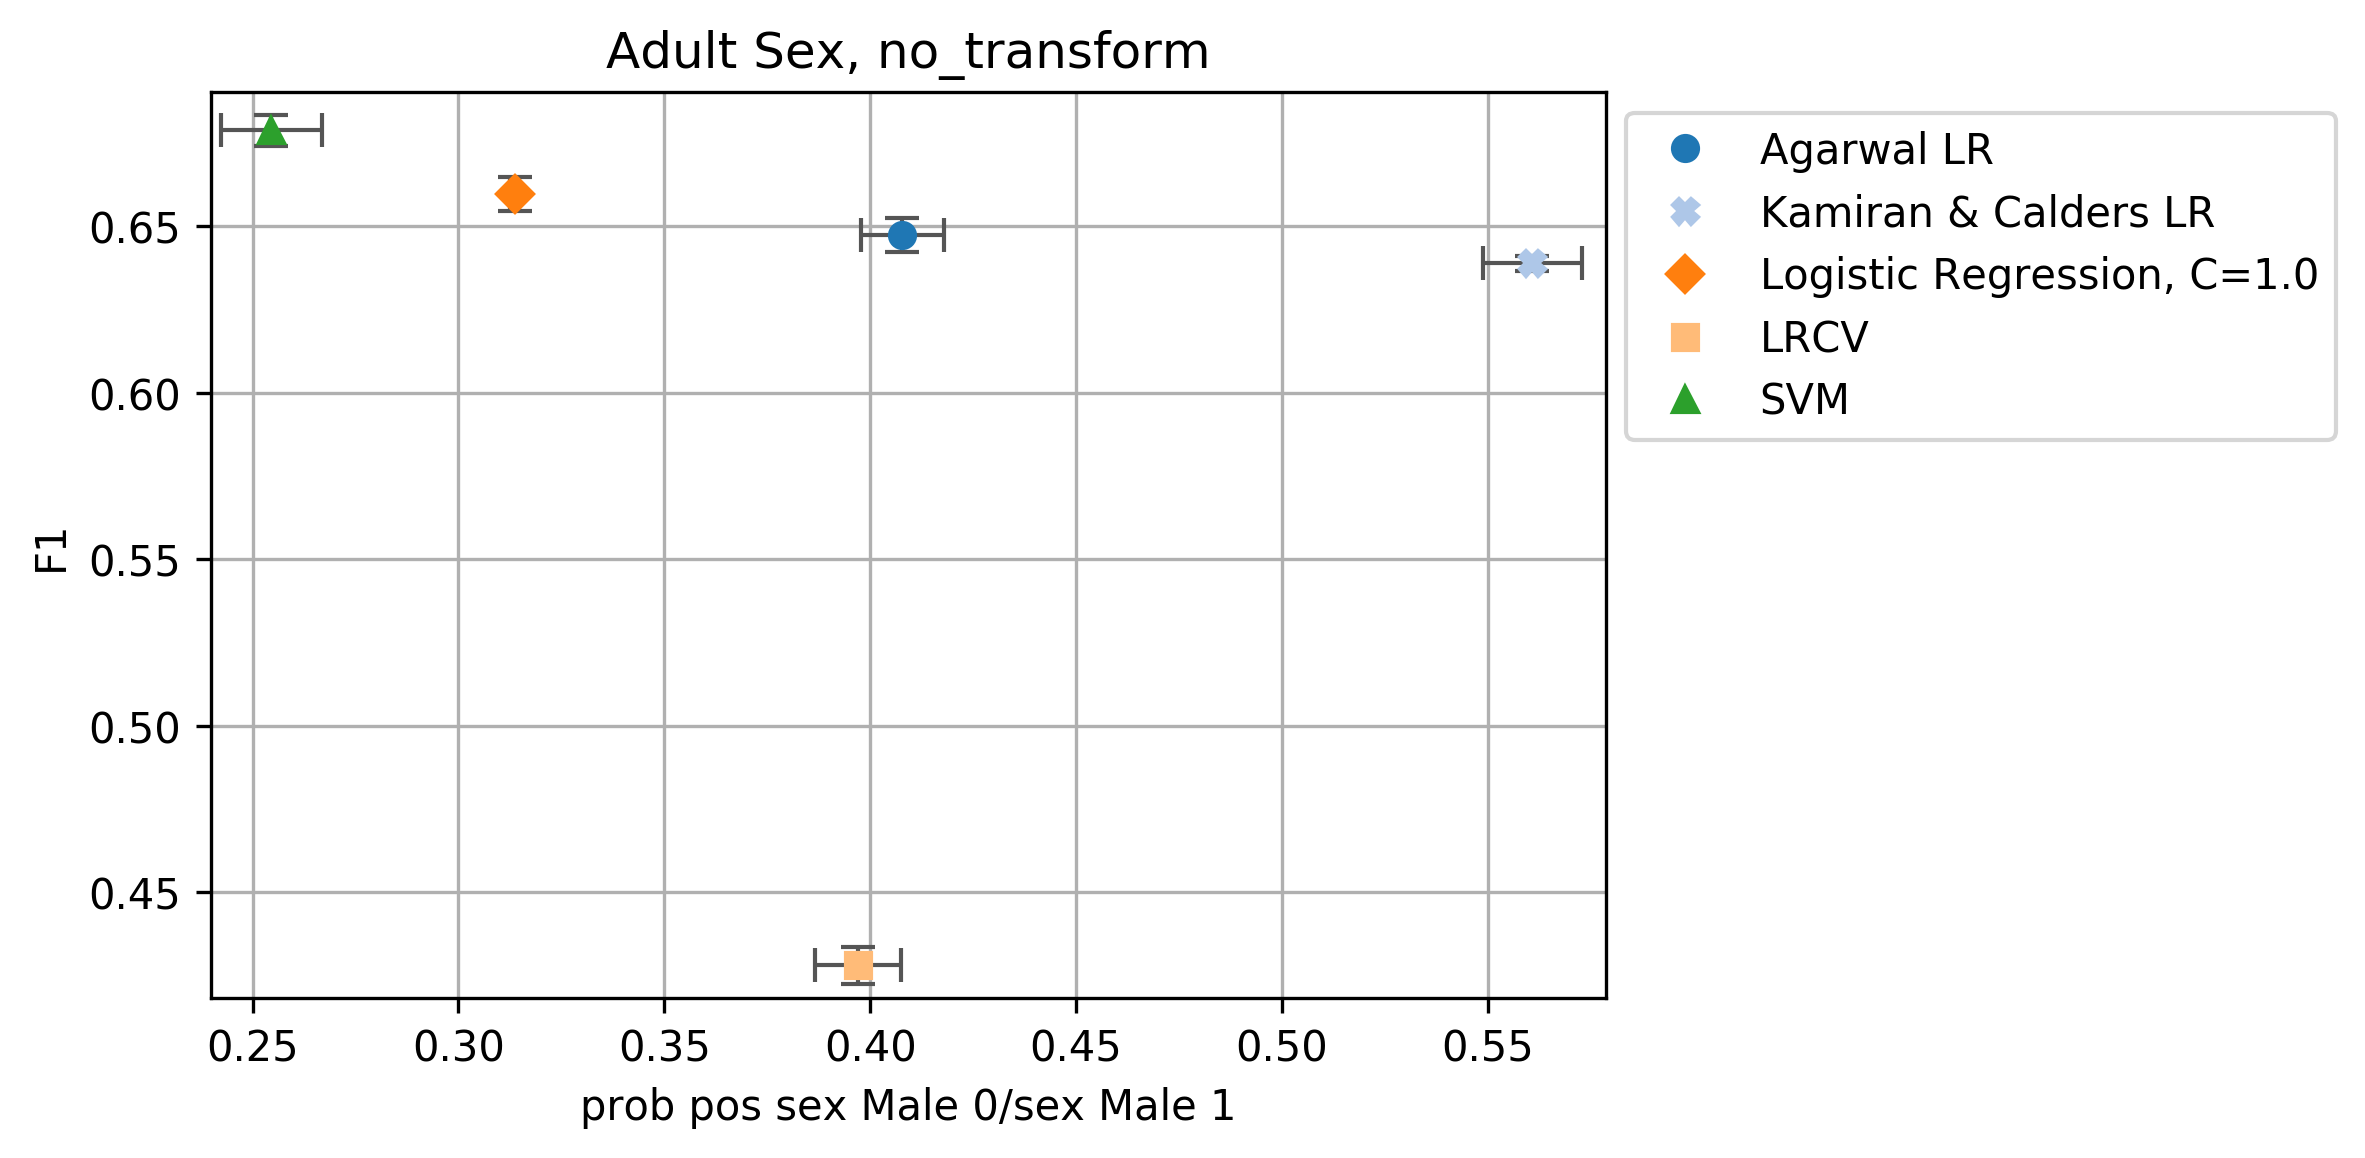

In [12]:
plot_results(dp_results, "F1", "prob_pos_sex_Male_0/sex_Male_1", save=False, ptype="cross")[0][0]

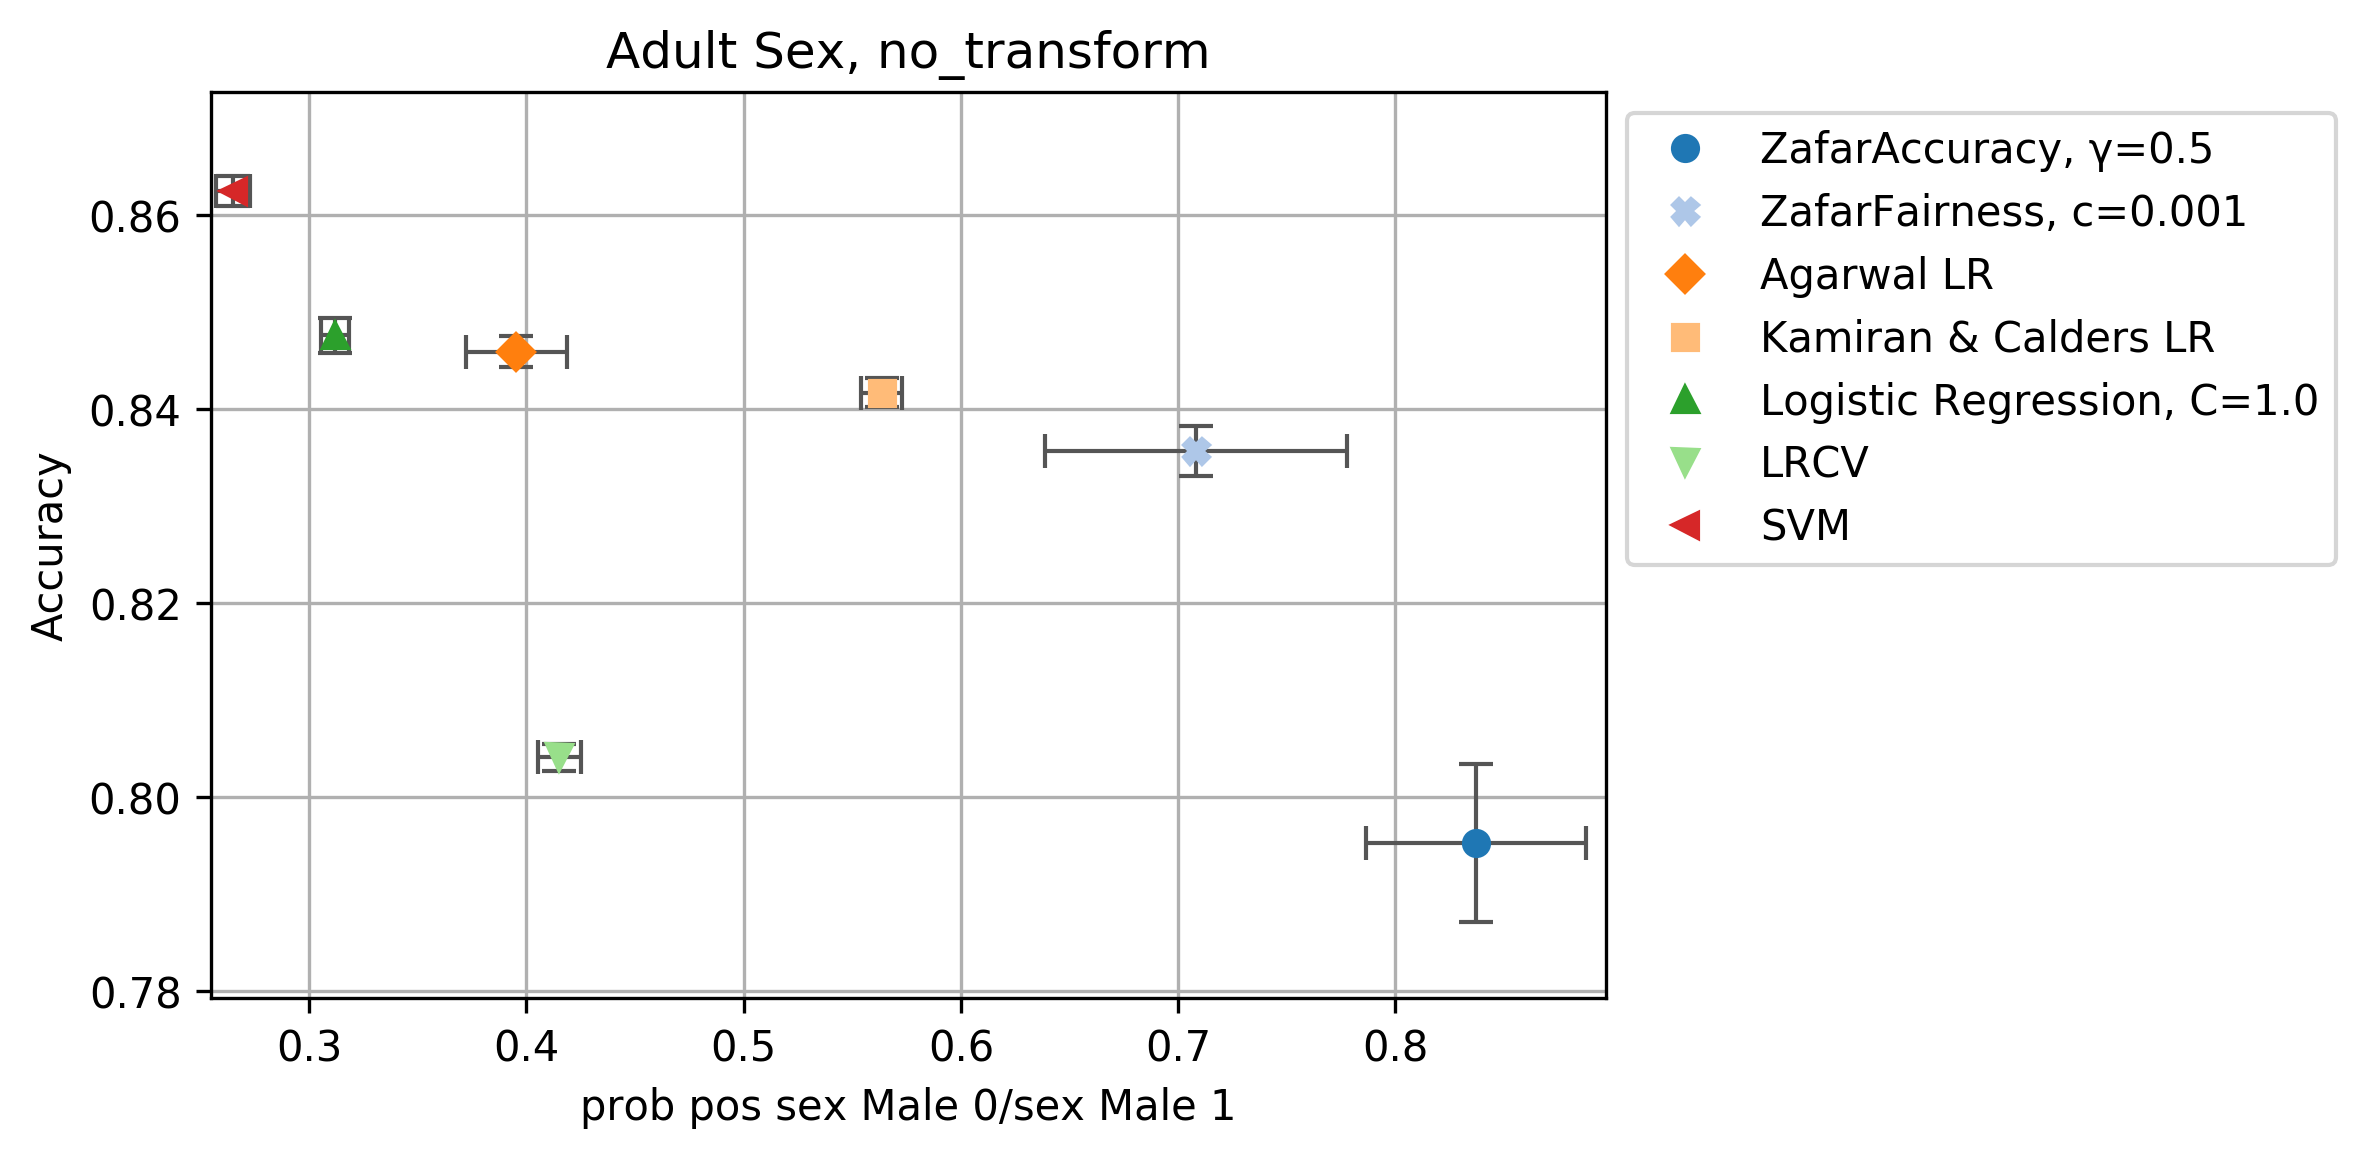

In [6]:
plot_results(dp_results, "Accuracy", "prob_pos_sex_Male_0/sex_Male_1", save=False, ptype="cross")[0][0]